In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# Define Image Preprocessing
transform = transforms.Compose([
    transforms.Resize((1038, 1920)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
def load_dataset(data_path):
    dataset = datasets.ImageFolder(data_path, transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)
    return dataloader

# Display sample images
def imshow(tensor):
    image = tensor.clone().detach().cpu().numpy().transpose(1, 2, 0)
    image = image * 0.229 + 0.485  # Unnormalize
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [3]:
dataloader = load_dataset("dataset")
sample_images, _ = next(iter(dataloader))

/home/vanilla_skies/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vanilla_skies/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].


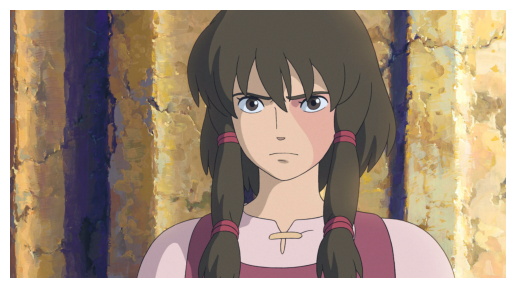

In [4]:
imshow(sample_images[0])

In [6]:
def get_vgg19():
    vgg = models.vgg19(pretrained=True).features.eval()
    for param in vgg.parameters():
        param.requires_grad_(False)
    
    # We'll need these specific layers for style and content
    style_layers = ['0', '5', '10', '19', '28']  # Conv layers
    content_layers = ['21']  # Deeper conv layer for content
    
    return vgg, style_layers, content_layers

def get_features(image, model, layers):
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[name] = x
    return features

def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

def style_transfer_with_loader(content_image, dataloader, model, style_layers, content_layers, 
                             num_steps=300, style_weight=1000000, content_weight=1):
    # Get device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load model and content image
    model = model.to(device)
    content_image = content_image.to(device)
    
    # Get content features only once
    content_features = get_features(content_image, model, content_layers)
    
    # Initialize style grams dictionary
    style_grams = {layer: [] for layer in style_layers}
    
    # Process all style images from the dataloader
    with torch.no_grad():
        for batch_idx, (style_images, _) in enumerate(dataloader):
            style_images = style_images.to(device)
            
            # Get features for each style image in the batch
            for style_img in style_images:
                style_img = style_img.unsqueeze(0)  # Add batch dimension
                style_features = get_features(style_img, model, style_layers)
                
                # Calculate and store gram matrices
                for layer in style_layers:
                    style_grams[layer].append(gram_matrix(style_features[layer]))
    
    # Calculate average gram matrices across all style images
    for layer in style_layers:
        style_grams[layer] = torch.mean(torch.stack(style_grams[layer]), dim=0)
    
    # Initialize target image (start with content image)
    target = content_image.clone().requires_grad_(True).to(device)
    
    # Optimizer
    optimizer = torch.optim.LBFGS([target])
    
    # Training loop
    run = [0]
    while run[0] <= num_steps:
        def closure():
            # Clamp values to image range
            with torch.no_grad():
                target.clamp_(0, 1)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Get features from target image
            target_features = get_features(target, model, style_layers + content_layers)
            
            # Content loss
            content_loss = 0
            for layer in content_layers:
                content_loss += torch.mean((target_features[layer] - content_features[layer])**2)
            content_loss *= content_weight
            
            # Style loss
            style_loss = 0
            for layer in style_layers:
                target_gram = gram_matrix(target_features[layer])
                style_gram = style_grams[layer]
                style_loss += torch.mean((target_gram - style_gram)**2)
            style_loss *= style_weight
            
            # Total loss
            total_loss = style_loss + content_loss
            total_loss.backward()
            
            run[0] += 1
            if run[0] % 50 == 0:
                print(f"Step {run[0]}: Style Loss: {style_loss.item():.4f}, Content Loss: {content_loss.item():.4f}")
            
            return total_loss
        
        optimizer.step(closure)
    
    # Final clamp
    with torch.no_grad():
        target.clamp_(0, 1)
    
    return target

In [ ]:
vgg, style_layers, content_layers = get_vgg19()
    
# Load content image
content_image = Image.open("maeghal.jpg")  # Your content image path
content_tensor = transform(content_image).unsqueeze(0)

dataloader = load_dataset("dataset/")
    
# Run style transfer
output = style_transfer_with_loader(
    content_tensor, 
    dataloader, 
    vgg, 
    style_layers, 
    content_layers,
    num_steps=300,
    style_weight=1e6,
    content_weight=1
)

# Show result
imshow(output.squeeze())

# Save result
output_image = transforms.ToPILImage()(output.squeeze().cpu())
output_image.save("styled_output.jpg")